In [1]:
import torch
from torch import nn, optim
import torch.utils.data as torch_data
import torch.nn.functional as F
import itertools as it
import numpy as np
import random
from itertools import combinations, product
from mutex import EncDec, Vocab, batch_seqs, Mutex
from data import encode,  generate_fig2_exp, Oracle, collate, eval_format
from absl import app, flags
import sys

In [2]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import pandas as pd
plt.rcParams['figure.dpi'] = 250

In [3]:
input_symbols_list   = set(['dax', 'lug', 'wif', 'zup', 'fep', 'blicket', 'kiki', 'tufa', 'gazzer'])
output_symbols_list  = set(['RED', 'YELLOW', 'GREEN', 'BLUE', 'PURPLE', 'PINK'])

In [4]:
study, test = generate_fig2_exp(input_symbols_list, output_symbols_list)

color map:  {'zup': 'YELLOW', 'lug': 'BLUE', 'fep': 'GREEN', 'tufa': 'PURPLE'}
function names:  ['gazzer', 'dax', 'wif']


In [5]:
study

[(['zup'], ['YELLOW']),
 (['lug'], ['BLUE']),
 (['fep'], ['GREEN']),
 (['tufa'], ['PURPLE']),
 (['zup', 'gazzer'], ['YELLOW', 'YELLOW', 'YELLOW']),
 (['lug', 'gazzer'], ['BLUE', 'BLUE', 'BLUE']),
 (['lug', 'dax', 'tufa'], ['BLUE', 'PURPLE', 'BLUE']),
 (['zup', 'dax', 'tufa'], ['YELLOW', 'PURPLE', 'YELLOW']),
 (['fep', 'wif', 'tufa'], ['PURPLE', 'GREEN']),
 (['lug', 'wif', 'tufa'], ['PURPLE', 'BLUE']),
 (['lug', 'wif', 'lug', 'gazzer'], ['BLUE', 'BLUE', 'BLUE', 'BLUE']),
 (['zup', 'dax', 'tufa', 'gazzer'],
  ['YELLOW', 'PURPLE', 'PURPLE', 'PURPLE', 'YELLOW']),
 (['lug', 'wif', 'zup', 'dax', 'tufa'],
  ['YELLOW', 'PURPLE', 'YELLOW', 'BLUE']),
 (['zup', 'dax', 'zup', 'wif', 'lug'], ['BLUE', 'YELLOW', 'YELLOW', 'YELLOW'])]

In [6]:
test

[(['tufa', 'gazzer'], ['PURPLE', 'PURPLE', 'PURPLE']),
 (['fep', 'gazzer'], ['GREEN', 'GREEN', 'GREEN']),
 (['fep', 'dax', 'tufa'], ['GREEN', 'PURPLE', 'GREEN']),
 (['zup', 'dax', 'lug'], ['YELLOW', 'BLUE', 'YELLOW']),
 (['zup', 'wif', 'lug'], ['BLUE', 'YELLOW']),
 (['zup', 'wif', 'tufa'], ['PURPLE', 'YELLOW']),
 (['tufa', 'dax', 'fep', 'gazzer'],
  ['PURPLE', 'GREEN', 'GREEN', 'GREEN', 'PURPLE']),
 (['tufa', 'dax', 'tufa', 'gazzer'],
  ['PURPLE', 'PURPLE', 'PURPLE', 'PURPLE', 'PURPLE']),
 (['lug', 'dax', 'tufa', 'wif', 'tufa'], ['PURPLE', 'BLUE', 'PURPLE', 'BLUE']),
 (['tufa', 'gazzer', 'wif', 'zup', 'dax', 'tufa'],
  ['YELLOW', 'PURPLE', 'YELLOW', 'PURPLE', 'PURPLE', 'PURPLE']),
 (['lug', 'gazzer', 'wif', 'tufa', 'dax', 'lug'],
  ['PURPLE', 'BLUE', 'PURPLE', 'BLUE', 'BLUE', 'BLUE'])]

In [7]:
FLAGS = flags.FLAGS
flags_dict = FLAGS._flags()
keys_list = [keys for keys in flags_dict]
for keys in keys_list: delattr(FLAGS,keys)
flags.DEFINE_integer("dim", 200, "trasnformer dimension")
flags.DEFINE_integer("n_layers", 1, "number of rnn layers")
flags.DEFINE_integer("n_batch", 1, "batch size")
flags.DEFINE_integer("n_epochs",50, "number of training epochs")
flags.DEFINE_float("lr", 0.001, "learning rate")
flags.DEFINE_float("dropout", 0.05, "dropout")
flags.DEFINE_string("save_model", "model.m", "model save location")
flags.DEFINE_integer("seed", 0, "random seed")
FLAGS(['mutex.ipynb'])

['mutex.ipynb']

In [8]:
DEVICE = torch.device("cuda:0")

In [9]:
def pretrain(model, train_dataset, val_dataset):
    opt = optim.Adam(model.parameters(), lr=FLAGS.lr)
    train_loader = torch_data.DataLoader(
        train_dataset, batch_size=FLAGS.n_batch, shuffle=False, 
        collate_fn=collate
    )
    best_loss  = np.inf
    for i_epoch in range(FLAGS.n_epochs):
        model.train()
        train_loss = 0
        train_batches = 0
        for inp, _ in train_loader:
            x = inp[:-1,:]
            pred, *extras = model(None, x.shape[0], x.to(DEVICE))
            output = pred.view(-1, len(model.vocab))
            loss = model.nllreduce(output,inp[1:, :].view(-1).to(DEVICE))
            opt.zero_grad()
            loss.backward()
#             nn.utils.clip_grad_norm_(model.parameters(), 0.5)
            opt.step()
            train_loss    += loss.item() * inp.shape[1]
            train_batches += inp.shape[1]

        if (i_epoch + 1) % 3 != 0:
            continue

        curr_loss = train_loss / train_batches
        best_loss = min(best_loss, curr_loss)
        print(curr_loss)
        torch.save(model.state_dict(), FLAGS.save_model)

    print("best_loss", best_loss)

    
    
def train(model, train_dataset, val_dataset):
    opt = optim.Adam(model.parameters(), lr=FLAGS.lr)
    train_loader = torch_data.DataLoader(
        train_dataset, batch_size=FLAGS.n_batch, shuffle=False, 
        collate_fn=collate
    )
    best_f1  = -np.inf
    best_acc = -np.inf
    for i_epoch in range(FLAGS.n_epochs):
        model.train()
        train_loss = 0
        train_batches = 0
        for inp, out in train_loader:
            nll = model(inp.to(DEVICE), out.to(DEVICE))
            loss = nll.mean()
            opt.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 0.5)
            opt.step()
            train_loss += loss.item()
            train_batches += 1
        
        if (i_epoch + 1) % 3 != 0:
            continue
            
        
        print(train_loss / train_batches)
        acc, f1 = validate(model, val_dataset)
        print(f"epoch_{i_epoch}_acc", acc)
        print(f"epoch_{i_epoch}_f1", f1)
        best_f1 = max(best_f1, f1)
        best_acc = max(best_acc, acc)
        print()
        torch.save(model.state_dict(), FLAGS.save_model)

    print("final_acc", acc)
    print("final_f1", f1)
    print("best_acc", best_acc)
    print("best_f1", best_f1)


def validate(model, val_dataset, vis=False, tag=[]):
    model.eval()
    first = True
    val_loader = torch_data.DataLoader(
        val_dataset, batch_size=FLAGS.n_batch, shuffle=True, 
        collate_fn=collate
    )
    total = 0
    correct = 0
    tp = 0
    fp = 0
    fn = 0
    with torch.no_grad():
        for inp, out in val_loader:
            pred, _ = model.sample(inp.to(DEVICE), temp=1.0, max_len=3, greedy=True)
            for i, seq in enumerate(pred):
                ref = out[:, i].detach().cpu().numpy().tolist()
                ref = eval_format(model.vocab, ref)
                pred_here = eval_format(model.vocab, pred[i])
                correct_here = pred_here == ref
                correct += correct_here
                tp_here = len([p for p in pred_here if p in ref])
                tp += tp_here
                fp_here = len([p for p in pred_here if p not in ref])
                fp += fp_here
                fn_here = len([p for p in ref if p not in pred_here])
                fn += fn_here
                path = "/" + "/".join(tag)
                if vis:
                    print(f"@{path}/{total}", correct_here, tp_here, fp_here, fn_here)
                    inp_lst = inp[:, i].detach().cpu().numpy().tolist()
                    print(eval_format(model.vocab, inp_lst))
                    print("gold", ref)
                    print("pred", pred_here)
                    print(pred_here == ref)
                    print()
                total += 1

    acc = correct / total
    if tp+fp > 0:
        prec = tp / (tp + fp)
    else:
        prec=0
    rec = tp / (tp + fn)
    if prec == 0 or rec == 0:
        f1 = 0
    else:
        f1 = 2 * prec * rec / (prec + rec)
    return acc, f1

def swap_io(items):
    return [(y,x) for (x,y) in items]

In [10]:
def main(model=None):
    np.random.seed(FLAGS.seed)
    torch.manual_seed(FLAGS.seed)
    vocab = Vocab()
    for sym in input_symbols_list.union(output_symbols_list): 
        vocab.add(sym)
        
    study, test = generate_fig2_exp(input_symbols_list, output_symbols_list)
#     for (x,y) in study[0:4]:
#         for sym in x+y:
# #             vocab.add(sym)
    test  = study[3:4]
    study  = study[0:3]
  
    
    train_items, test_items = encode(study,vocab), encode(test,vocab)
    


    outlist = list(output_symbols_list)

    oracle_py  = Oracle(vocab, train_items, test_items, DEVICE, dist="py")
    oracle_px  = Oracle(vocab, train_items, test_items, DEVICE, dist="px")
    oracle_qxy = Oracle(vocab, train_items, test_items, DEVICE, dist="qxy")
    
    if model is None:
        model = Mutex(vocab, 
                      FLAGS.dim, 
                      FLAGS.dim, 
                      oracle_py, 
                      max_len=3,
                      copy=False, 
                      n_layers=FLAGS.n_layers, 
                      self_att=False, 
                      dropout=FLAGS.dropout,
                      lamda=0.1,
                      Nsample=50,
                     ).to(DEVICE)
    
    if not isinstance(model.px,Oracle):
        pretrain(model.px, train_items + test_items, test_items)
        
    print("px samples: ")
    print(model.sample_px(50))
    print("py samples: ")
    print(model.sample_py(50))
    
    if not isinstance(model.qxy,Oracle):
        train(model.qxy, swap_io(train_items) + swap_io(test_items), swap_io(test_items))
    if not isinstance(model.pyx,Oracle):
        train(model.pyx, train_items + test_items, test_items)
    
    print("qxy samples: ", model.sample_qxy(model.py.sample(5,5),temp=1.0))
    
    train(model, train_items, test_items)
    return model, study, test

In [11]:
model, study, test = main()

color map:  {'zup': 'YELLOW', 'tufa': 'GREEN', 'wif': 'PURPLE', 'gazzer': 'PINK'}
function names:  ['kiki', 'dax', 'fep']
1.091434121131897
0.7090440094470978
0.6965846121311188
0.770561695098877
0.7570958733558655
0.6909019947052002
0.6873876750469208
0.7198939025402069
0.7499990463256836
0.7082619965076447
0.7129162549972534
0.7186354100704193
0.6641131043434143
0.7455257773399353
0.6704261898994446
0.7045309543609619
best_loss 0.6641131043434143
px samples: 
['<s> wif </s>', '<s> wif </s>', '<s> wif </s>', '<s> wif </s>', '<s> zup </s>', '<s> wif </s>', '<s> zup </s>', '<s> tufa </s>', '<s> tufa </s>', '<s> zup </s>', '<s> tufa </s>', '<s> wif </s>', '<s> wif </s>', '<s> tufa </s>', '<s> gazzer </s>', '<s> gazzer </s>', '<s> gazzer </s>', '<s> tufa </s>', '<s> tufa </s>', '<s> tufa </s>', '<s> tufa </s>', '<s> tufa </s>', '<s> zup </s>', '<s> tufa </s>', '<s> gazzer </s>', '<s> wif </s>', '<s> gazzer </s>', '<s> tufa </s>', '<s> wif </s>', '<s> zup </s>', '<s> zup </s>', '<s> tufa <

In [12]:
print("qxy samples: ", model.sample_qxy(model.py.sample(5,5),temp=4.0))

qxy samples:  ['<s> zup </s>', '<s> tufa </s>', '<s> wif </s>', '<s> gazzer </s>', '<s> tufa </s>']


In [13]:
validate(model, encode(test,model.vocab), vis=True)

@//0 False 0 1 1
['gazzer']
gold ['PINK']
pred ['GREEN']
False



(0.0, 0)

In [14]:
validate(model, encode(study,model.vocab), vis=True)

@//0 True 1 0 0
['zup']
gold ['YELLOW']
pred ['YELLOW']
True

@//1 True 1 0 0
['wif']
gold ['PURPLE']
pred ['PURPLE']
True

@//2 True 1 0 0
['tufa']
gold ['GREEN']
pred ['GREEN']
True



(1.0, 1.0)

In [15]:
model.loss_container

[LossTrack(nll=4.76837158203125e-05, mlogpyx=4.024505687993951e-05, pointkl=1.4045214653015137),
 LossTrack(nll=5.1021575927734375e-05, mlogpyx=3.699302760651335e-05, pointkl=1.3844189643859863),
 LossTrack(nll=5.8650970458984375e-05, mlogpyx=2.57015235547442e-05, pointkl=1.4325077533721924),
 LossTrack(nll=4.76837158203125e-07, mlogpyx=0.08963920921087265, pointkl=1.3366895914077759),
 LossTrack(nll=4.76837158203125e-06, mlogpyx=0.08803200721740723, pointkl=1.1730310916900635),
 LossTrack(nll=1.0013580322265625e-05, mlogpyx=0.3674713373184204, pointkl=1.2802855968475342),
 LossTrack(nll=4.76837158203125e-07, mlogpyx=1.1313341856002808, pointkl=1.0819692611694336),
 LossTrack(nll=1.430511474609375e-06, mlogpyx=1.689367651939392, pointkl=0.9541357755661011),
 LossTrack(nll=1.811981201171875e-05, mlogpyx=1.458018183708191, pointkl=0.9219838380813599),
 LossTrack(nll=0.00021314620971679688, mlogpyx=1.2286665439605713, pointkl=0.7236261367797852),
 LossTrack(nll=2.1457672119140625e-05, mlo

In [16]:
df = pd.DataFrame(model.loss_container)

In [17]:
df

,nll,mlogpyx,pointkl
0,4.768372e-05,0.000040,1.404521
1,5.102158e-05,0.000037,1.384419
2,5.865097e-05,0.000026,1.432508
3,4.768372e-07,0.089639,1.336690
4,4.768372e-06,0.088032,1.173031
...,...,...,...
145,1.166892e-02,0.749294,-0.001650
146,1.479387e-03,0.797838,0.006143
147,9.249449e-03,0.850270,0.027524
148,2.648592e-03,0.795079,-0.019415


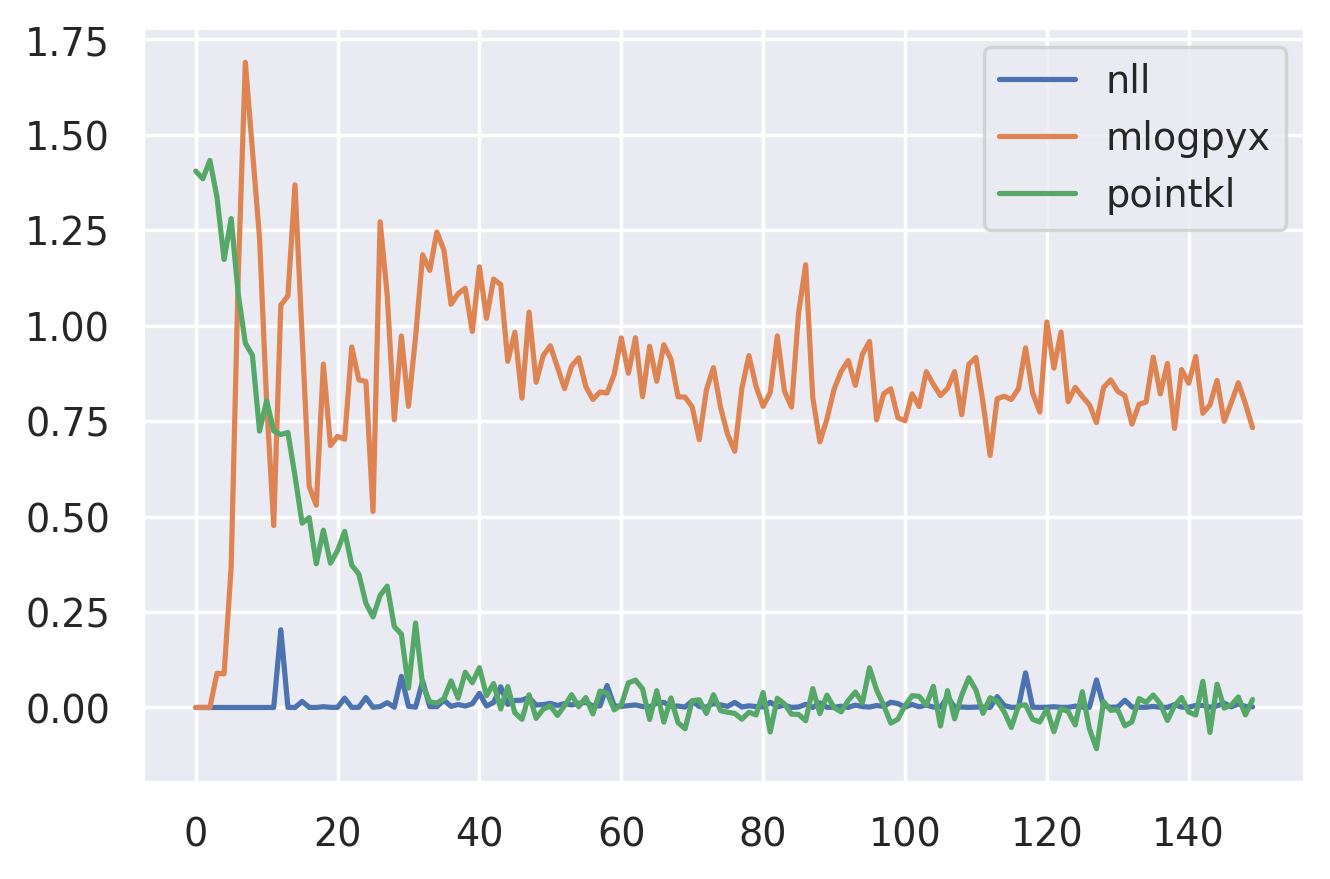

In [18]:
ax = sns.lineplot(data=df, dashes=False)